# 変分自己符号化器（variational autoencoder, VAE）

ここでは、Kerasを用いて、変分自己符号器の学習を行う。

In [1]:
%matplotlib inline

from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import backend as K
from keras import metrics,optimizers
from keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd

Using TensorFlow backend.


### MNISTデータの読み込み

In [2]:
# Load the MNIST dataset
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(X_train, y_train),(X_test, y_test) = mnist.load_data()

# 28*28の画像データを784のベクトルに変換する
X_train = X_train.reshape(-1, 784) / 255
X_test = X_test.reshape(-1, 784) / 255

# one-hotベクトルに変換
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

### 条件設定

In [3]:
batch_size = 100 # バッチサイズ
original_dim = 784 # 入力層のノード数
latent_dim = 2 # 潜在変数の次元数
intermediate_dim = 256 # 中間層のノード数
epochs = 10 # エポック数

### モデルの定義

In [4]:
# サンプリング用の関数
def sampling(args):
    
    # 引数を平均値と標準偏差の対数にわける
    z_mean, z_sigma = args
    
    # 標準正規分布からepsilonをサンプリングする
    epsilon = K.random_normal(shape=(latent_dim,), mean=0., stddev=1.0)
    
    # サンプリングしたepsilonをスケール&シフトさせてreturn
    return z_mean + z_sigma * epsilon


# VAEのネットワーク構成を定義
x = Input(shape=(original_dim,)) # 入力層
h = Dense(intermediate_dim, activation='relu')(x) # encoderの中間層
z_mean = Dense(latent_dim)(h) # 平均値(と解釈させる)
z_sigma = Dense(latent_dim)(h) # 標準偏差(と解釈させる)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_sigma]) # サンプリング
decoder_h = Dense(intermediate_dim, activation='relu') # decoderの中間層
h_decoded = decoder_h(z) # サンプリングした結果をdecoderの中間層に入れる
decoder_mean =  Dense(original_dim, activation='sigmoid')  # 出力層の定義
x_decoded_mean = decoder_mean(h_decoded) # decoderの中間層の出力を出力層に入れる


# 損失関数
xent_loss = original_dim * metrics.binary_crossentropy(x, x_decoded_mean)
kl_loss = - 0.5 * K.sum(1 + K.log(K.square(z_sigma)) - K.square(z_mean) - K.square(z_sigma), axis=-1)
vae_loss = K.mean(xent_loss + kl_loss)


# VAEのモデルを生成
vae = Model(inputs=x, outputs=x_decoded_mean)
vae.add_loss(vae_loss)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9)
#adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999)
vae.compile(optimizer=rmsprop)
vae.summary()

W0421 14:08:45.261137 4665570752 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0421 14:08:45.324388 4665570752 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0421 14:08:45.331966 4665570752 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0421 14:08:45.472153 4665570752 deprecation_wrapper.py:119] From /Users/ogata/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 784)          0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          200960      input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 2)            514         dense_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (

### VAEを訓練

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 14s 238us/step - loss: 198.6855 - val_loss: 176.7973
Epoch 2/10
60000/60000 [==============================] - 14s 225us/step - loss: 174.5702 - val_loss: 171.2741
Epoch 3/10
60000/60000 [==============================] - 14s 229us/step - loss: 170.0717 - val_loss: 169.5952
Epoch 4/10
60000/60000 [==============================] - 14s 227us/step - loss: 167.5823 - val_loss: 166.5076
Epoch 5/10
60000/60000 [==============================] - 13s 224us/step - loss: 165.7887 - val_loss: 164.6971
Epoch 6/10
60000/60000 [==============================] - 13s 224us/step - loss: 164.4188 - val_loss: 163.3891
Epoch 7/10
60000/60000 [==============================] - 14s 231us/step - loss: 163.1279 - val_loss: 162.5742
Epoch 8/10
60000/60000 [==============================] - 22s 367us/step - loss: 161.9900 - val_loss: 161.4023
Epoch 9/10
60000/60000 [==============================] - 14s 

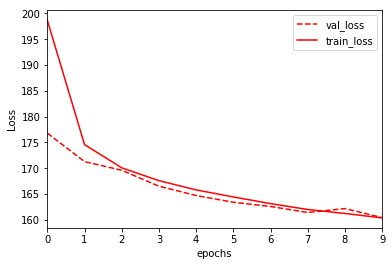

In [5]:
history = vae.fit(X_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, None))

# 計算過程の描画
df_log = pd.DataFrame(history.history)
df_log.rename(columns={"loss":"train_loss"}, inplace=True)
df_log.plot(style=['r--', 'r-'])
plt.ylabel("Loss")
plt.xlabel("epochs")
plt.show()

### 隠れ変数z_meanの可視化
encoderにx_testを入力することで、隠れ変数のz_meanを出力する

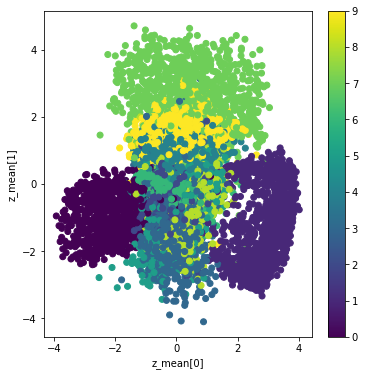

In [6]:
# 入力を潜在空間に投影するためのモデル
encoder = Model(x, z_mean)

# テストデータを入力して潜在空間に2次元プロットする 正解ラベルを色で表示
x_test_encoded = encoder.predict(X_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=np.argmax(y_test, axis=1))
plt.xlabel("z_mean[0]")
plt.ylabel("z_mean[1]")
plt.colorbar()
plt.show()

* クラスごとにまとまっているため、クラスごとの特徴をうまく捉えられていると言える

### 画像を生成し表示
decoderにz_sampleを入力し、画像を生成する。z_sampleは、2次元標準正規分布からサンプリングされた値を想定している。

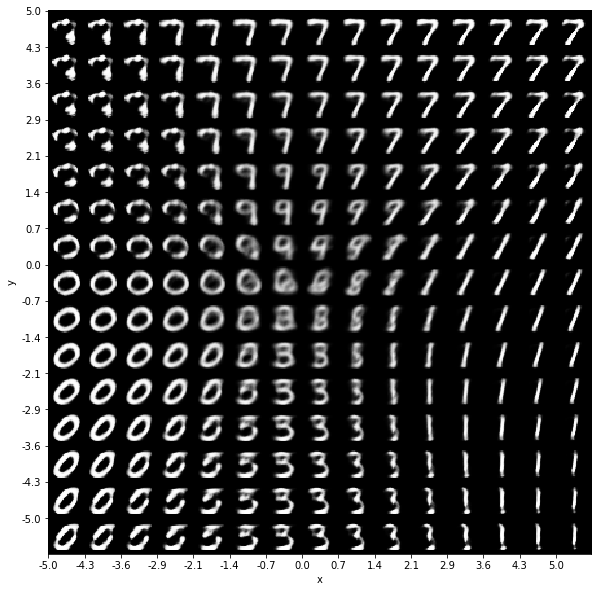

In [7]:
# 画像の生成器を作成
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

# 画像を並べて表示
n = 15  # 画像を15個x15個並べて表示
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 2次元標準正規分布を作成してグリッドにする
grid_x = np.linspace(-5, 5, n)
grid_y = np.linspace(-5, 5, n)


# 2次元標準正規分布の各値をdecoderに入力し、画像を生成
for i, xi in enumerate(grid_x):
    for j, yi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[(len(grid_y)-1-j) * digit_size: (len(grid_y)-1-j+1) * digit_size,
                       i * digit_size: (i+1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.yticks(np.arange(0,n*28,28), grid_y[::-1].round(1)) # [::-1]をつけると逆順になる
plt.xticks(np.arange(0,n*28,28), grid_x.round(1))
plt.xlabel("x")
plt.ylabel("y")
plt.show()

隠れ変数z_meanの可視化の図と対応している事がわかる

### [演習]
* Epoch数を増やすと結果がどのように変わるか確認してみましょう